In [2]:
# !unzip /content/drive/MyDrive/Datasets/GRAYSCALE.zip

## Import Modules

In [3]:
# Import All Necessary Modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from keras import layers, Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dropout, Dense, Flatten, MaxPooling2D, Rescaling 
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC ,SVR
import os
import random


## Helper Functions

In [4]:
# Plot the validation and training curves separately
def plot_loss_curve(history):
  '''
  Returns seperate loss curves for training and valdation metrics.
  '''
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy=history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='Training Loss')
  plt.plot(epochs, val_loss, label='Validation Loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='Training Accuracy')
  plt.plot(epochs, val_accuracy, label='Validation Accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

In [5]:
def show_results(modelname,test, pred):
    accuracy = accuracy_score(test, pred)
    precision=precision_score(test, pred, average='weighted')
    f1score=f1_score(test, pred, average='weighted')
    
    print(f'{modelname} Accuracy: {accuracy}\n')
    print(f'{modelname} Precision: {precision}\n')
    print(f'{modelname} f1-Score: {precision}\n')

    results=[(modelname,"Accuracy",accuracy),(modelname,"Precision",precision),(modelname,"F1Score",f1score)]
    return results

In [6]:
def make_confusion_matrix(confusion_matrix, class_names, figsize = (20,12), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [7]:
def visualization(X, Y):
    f = plt.figure(figsize=(20, 30))
    cols = 10
    rows = 10
    for i in range(0,50):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if Y is not None:
            sp.set_title(random.choice(class_names), fontsize=16)
            plt.imshow(X[i], cmap='gray')

## 01. Getting The Dataset

In [8]:
root_dir = '/content/GRAYSCALE/'

In [9]:
# Get all the class names as a list
class_names = []
for types in os.listdir(root_dir):
    class_names.append(types)
print(class_names)

['AutoRun', 'Gafgyt', 'RTM', 'Qshell', 'SDrop', 'Dinwod', 'Infy', 'Qbot', 'Winwebsec', 'NetWireRAT', 'Safebits', 'GrandCrab', 'OnlinerSpambot', 'Mansabo', '7ev3n', 'Emotet', 'Predator the Thief', 'Lokibot', 'IcedId', 'Mirai', 'GlobelImposter', 'Mokes', 'Fareit', 'Formbook', 'Koadic', 'REvil', 'Scar', 'Upatre', 'Mediyes', 'Padodor', 'Sakula', 'Blacksoul', 'Nuker', 'Zeus']


In [10]:
# Number of classes 
num_classes = len(class_names)
print(num_classes)

34


In [11]:
# Counting total image files
number_label = {}
total_files = 0
for i in os.listdir(root_dir):
    counting = len(os.listdir(os.path.join(root_dir, i)))
    number_label[i] = counting
    total_files += counting

print("Total Files : " + str(total_files))

Total Files : 16550


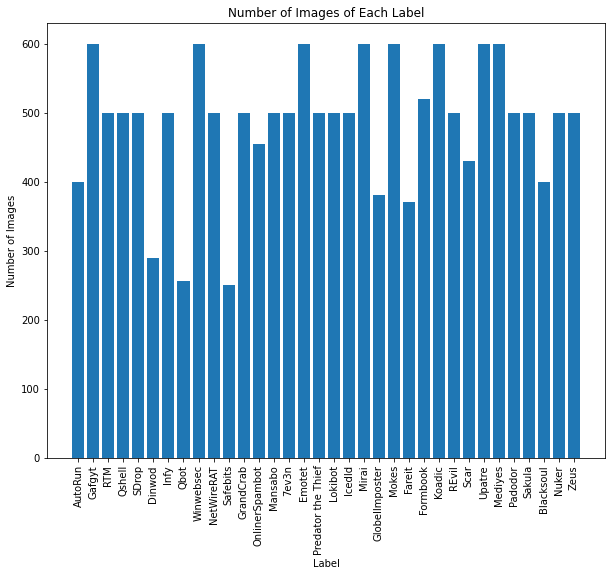

In [12]:
# Visualization of the number of images per class
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.bar(number_label.keys(), number_label.values());
plt.xticks(rotation='vertical')
plt.title("Number of Images of Each Label");
plt.xlabel('Label');
plt.ylabel('Number of Images');

## 02. Prepare Malware Image Data

In [13]:
IMG_SIZE=224

data = []
def create_dataset():
    for category in class_names:  
        path = os.path.join(root_dir,category)
        # get the classification labels
        class_num = class_names.index(category)  
        # iterate over each image 
        for img in tqdm(os.listdir(path)):  
            try:
                # convert to array
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)
                # resize image size
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  
                # add this to our training_dat
                data.append([new_array, class_num])
            except Exception as e: 
                print(e)

In [14]:
create_dataset()

100%|██████████| 500/500 [00:00<00:00, 895.70it/s]


In [15]:
print("Number of entries in training_data: ",end="")
print(len(data))
print("Entry at index 0 in Training Data\n")
print(data[0])
print("\nIt contains an image in 80x80 format and the associated label")
print("\nResized Image Size",end="")
print(data[0][0].shape)

Number of entries in training_data: 16550
Entry at index 0 in Training Data

[array([[ 77,  90, 144, ...,   0,   0,   0],
       [  0, 242,   0, ...,  97,   0,   0],
       [112,   0,   0, ...,   0,   0,   0],
       ...,
       [195, 103,  79, ..., 144, 233, 207],
       [ 26, 160, 234, ..., 108,  33,  68],
       [ 12, 132,  82, ...,  20, 144, 231]], dtype=uint8), 0]

It contains an image in 80x80 format and the associated label

Resized Image Size(224, 224)


In [16]:
# Including array features created from images and their labels into lists
X = []
Y = []
for features,label in data:
    X.append(features) # Image Features
    Y.append(label) # Image Labels

In [17]:
print(len(X))
print(len(Y))

16550
16550


In [18]:
# Convert Data & Label into numpy array
train = np.array(X) # Image Features Array
label = np.array(Y) # Image label Array
train.shape,label.shape

((16550, 224, 224), (16550,))

## 03. Malware Image Data Visualization

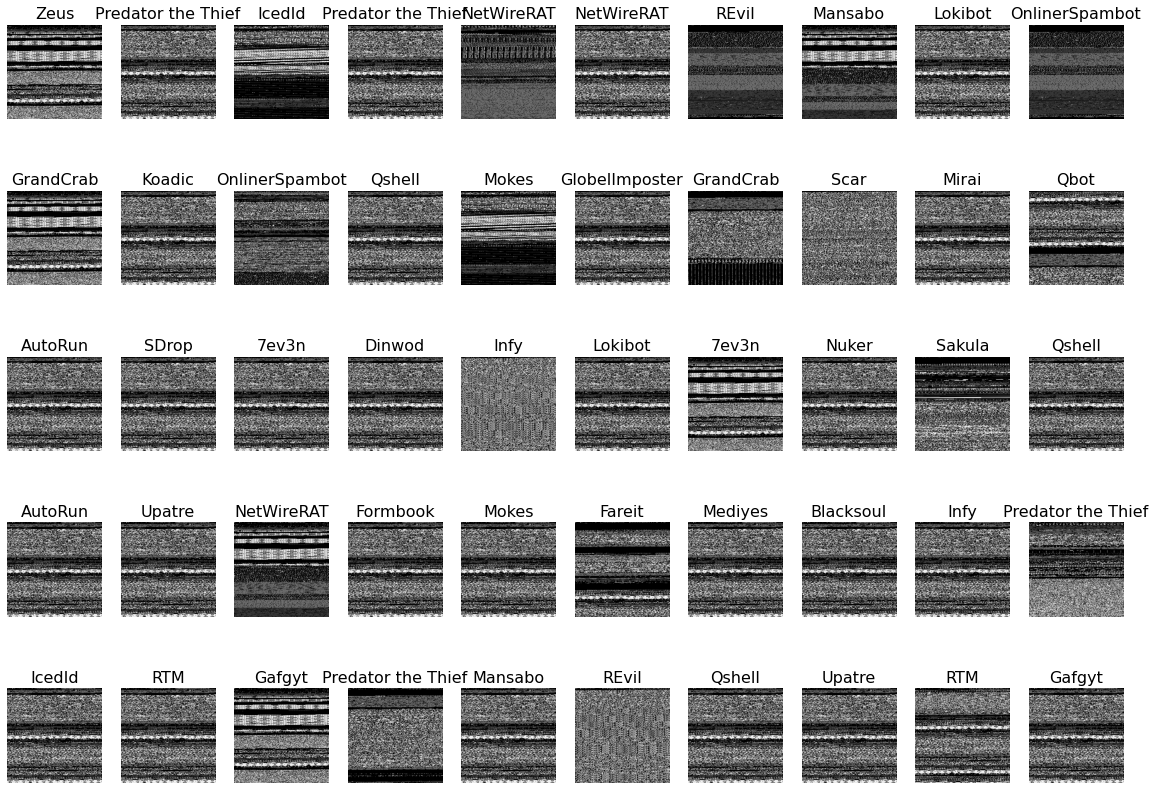

In [19]:
visualization(train, label)

In [20]:
# Reshape Data to be known as Grayscale Images
train = np.array(train).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

One hot encoding is a method used to label data sets that have multiple categories where order does not matter. To do this we is the **to_catgeorical()** function from the keras library.

In [21]:
# If our training data uses classes as numbers, to_categorical will transform those numbers in proper vectors for using with models
label = to_categorical(label)
train,label = shuffle(train, label)
print(label.shape)

(16550, 34)


After images are loaded into a numpy array, we can split our training and testing data. We know that our images are organized in a numpy array. We splitted 80% as our training image & 20% as our testing image. 

In [22]:
# Split Training & Testing Data
x_train,x_test,y_train,y_test = train_test_split(train,label,test_size=0.2, random_state=42)

In [23]:
x_train.shape

(13240, 224, 224, 1)

In [24]:
y_train.shape

(13240, 34)

In [25]:
x_test.shape

(3310, 224, 224, 1)

In [26]:
y_test.shape

(3310, 34)

## 03. Dual CNN Architecture

In [27]:
# CNN INPUT
my_input = tf.keras.Input(shape=(224, 224, 1))

**Rescaling:** A preprocessing layer which rescales input values to a new range. Values in the image range from 0 to 1.

**kernel_initializer:** Initializer for the kernel weights matrix.

**Dropout:** The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged. No values are dropped during inference.

In [28]:
# Create CNN Function for multiple use

def malware_model(user_input, cnn_id=1):
  model = Rescaling(1./255)(my_input)
  model = Conv2D(16, (3, 3), activation='relu', name='Conv_1_'+str(cnn_id))(model)   #kernel_initializer='he_normal',
  model = MaxPooling2D()(model)
  model = Conv2D(32, (3, 3), activation='relu', name='Conv_2_'+str(cnn_id))(model)
  model = MaxPooling2D()(model)
  model = Conv2D(64, (3, 3), activation='relu', name='Conv_3_'+str(cnn_id))(model)
  model = MaxPooling2D()(model)
  model = Dropout(0.15)(model)
  model = Conv2D(128, (3, 3), activation='relu', name='Conv_4_'+str(cnn_id))(model)
  model = MaxPooling2D()(model)
  model = Dropout(0.15)(model)
  model = Flatten()(model)
  model = Dense(512, activation='relu')(model)
  model = Dropout(0.15)(model)
  return model

In [29]:
# 1st CNN
cnn_1 = malware_model(my_input, 1)

# 2nd CNN
cnn_2 = malware_model(my_input, 2)

In [30]:
# Concatenate Two CNN Models
concat = layers.Concatenate()([cnn_1, cnn_2])

# Add a single Output Layer for Dual CNN
model = Dense(num_classes, activation='softmax')(concat)

# Build Final Model
cnnmodel = Model(inputs=my_input, outputs=model)

It takes a long time to train the neural network during fitting when the optimizer does have a lower learning rate. While taking a long time, it also helps in over fitting situations and correctly trains the data. 

### *(Model fitting is a measure of how well a machine learning model generalizes to similar data to that on which it was trained. A model that is well-fitted produces more accurate outcomes. A model that is overfitted matches the data too closely. A model that is underfitted doesn’t match closely enough.)*

In [31]:
# Lowering Optimizer Learning Rate
optimum= RMSprop(learning_rate=0.0001)


In [32]:
# Compile CNN Model
cnnmodel.compile(optimizer=optimum,
                loss= 'categorical_crossentropy',
                metrics=['accuracy'])

In [33]:
cnnmodel.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 1)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 1)  0           ['input_1[0][0]']                
                                                                                                  
 Conv_1_1 (Conv2D)              (None, 222, 222, 16  160         ['rescaling[0][0]']          

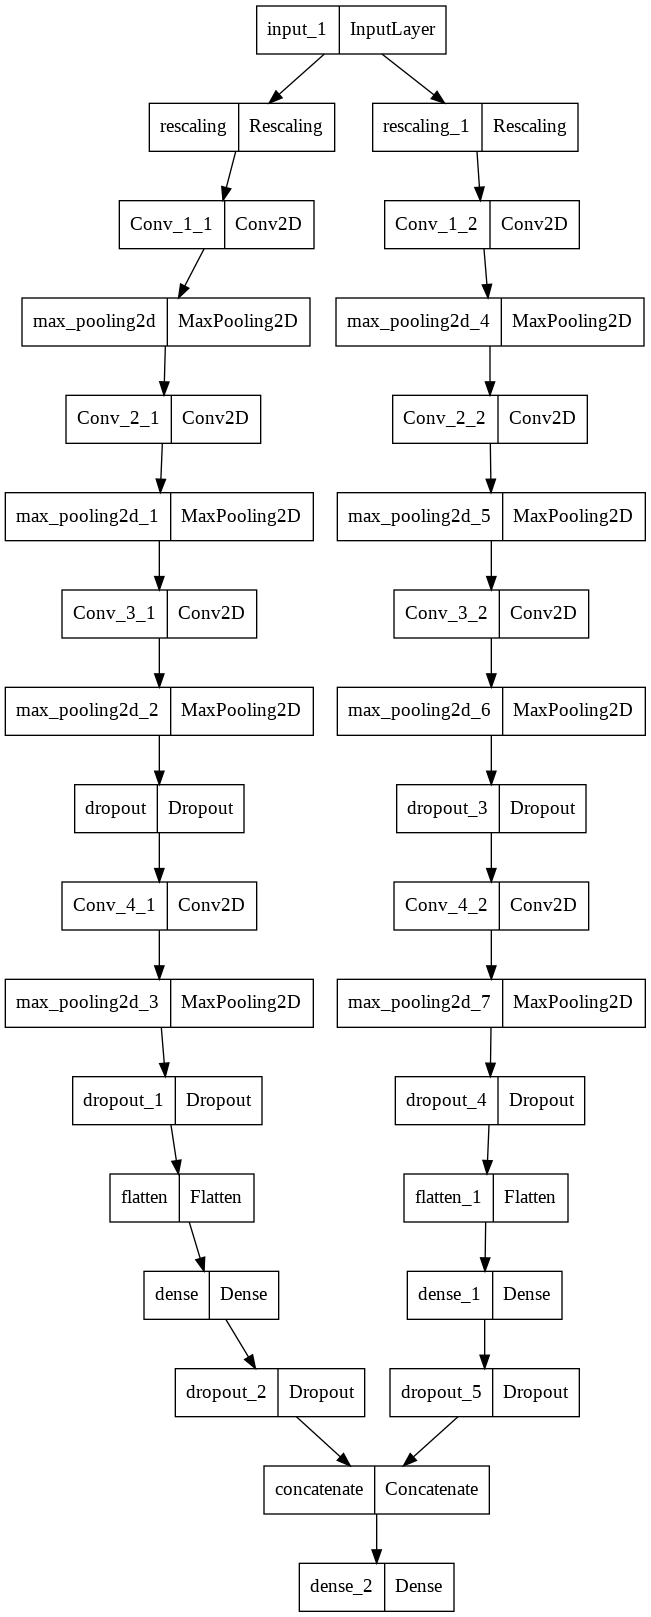

In [34]:
plot_model(cnnmodel, to_file='model.png')

In [35]:
history = cnnmodel.fit(x_train, y_train,
                       epochs=75,
                       validation_data = (x_test, y_test),
                       batch_size=32)

Epoch 1/75
414/414 [==============================] - 43s 70ms/step - loss: 1.4307 - accuracy: 0.6546 - val_loss: 0.6878 - val_accuracy: 0.8323
Epoch 2/75
414/414 [==============================] - 28s 68ms/step - loss: 0.4331 - accuracy: 0.8995 - val_loss: 0.3086 - val_accuracy: 0.9308
Epoch 3/75
414/414 [==============================] - 28s 68ms/step - loss: 0.2738 - accuracy: 0.9363 - val_loss: 0.2348 - val_accuracy: 0.9505
Epoch 4/75
414/414 [==============================] - 28s 69ms/step - loss: 0.1975 - accuracy: 0.9532 - val_loss: 0.1781 - val_accuracy: 0.9574
Epoch 5/75
414/414 [==============================] - 29s 70ms/step - loss: 0.1518 - accuracy: 0.9625 - val_loss: 0.1353 - val_accuracy: 0.9668
Epoch 6/75
414/414 [==============================] - 28s 68ms/step - loss: 0.1184 - accuracy: 0.9711 - val_loss: 0.1373 - val_accuracy: 0.9526
Epoch 7/75
414/414 [==============================] - 28s 69ms/step - loss: 0.0963 - accuracy: 0.9734 - val_loss: 0.0985 - val_accuracy:

In [36]:
# Evaluate model using Testing Data
eval = cnnmodel.evaluate(x_test,y_test)

104/104 [==============================] - 2s 20ms/step - loss: 0.1469 - accuracy: 0.9822


In [37]:
print(f'Accuracy: {eval[1]}')

Accuracy: 0.9821752309799194


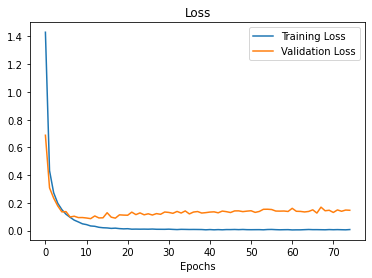

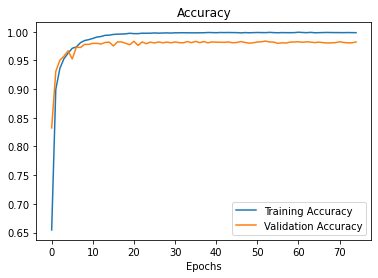

In [38]:
# Plot Accuracy & Loss Curve
plot_loss_curve(history)

In [39]:
# Predict CNN Model using Testing Data
cnn_pred = cnnmodel.predict(x_test,verbose=1)

104/104 [==============================] - 2s 17ms/step


In [40]:
# Get Maximum Predicted values using np.argmax
cnn_predict = np.argmax(cnn_pred, axis=1)

In [41]:
# Get Maximum Actual values using np.argmax
cnn_actual = np.argmax(y_test, axis=1)

In [42]:
# Showing DUAL CNN Accuracy Results
CNN_results = show_results("Dual CNN", cnn_actual, cnn_predict)

Dual CNN Accuracy: 0.9821752265861027

Dual CNN Precision: 0.982488275985196

Dual CNN f1-Score: 0.982488275985196



In [43]:
print(f'\t\t\tDual CNN Classification Report\n')
print(classification_report(cnn_actual, cnn_predict, target_names=class_names))

			Dual CNN Classification Report

                    precision    recall  f1-score   support

           AutoRun       1.00      0.99      0.99        78
            Gafgyt       0.95      0.94      0.95       122
               RTM       1.00      1.00      1.00       115
            Qshell       1.00      1.00      1.00        90
             SDrop       1.00      1.00      1.00       105
            Dinwod       1.00      0.98      0.99        54
              Infy       0.90      0.97      0.94       107
              Qbot       0.94      0.96      0.95        47
         Winwebsec       0.99      1.00      1.00       137
        NetWireRAT       0.97      0.99      0.98       110
          Safebits       1.00      0.97      0.98        61
         GrandCrab       0.97      0.99      0.98        98
    OnlinerSpambot       0.98      1.00      0.99        98
           Mansabo       0.97      1.00      0.98        94
             7ev3n       0.99      1.00      1.00       109
    

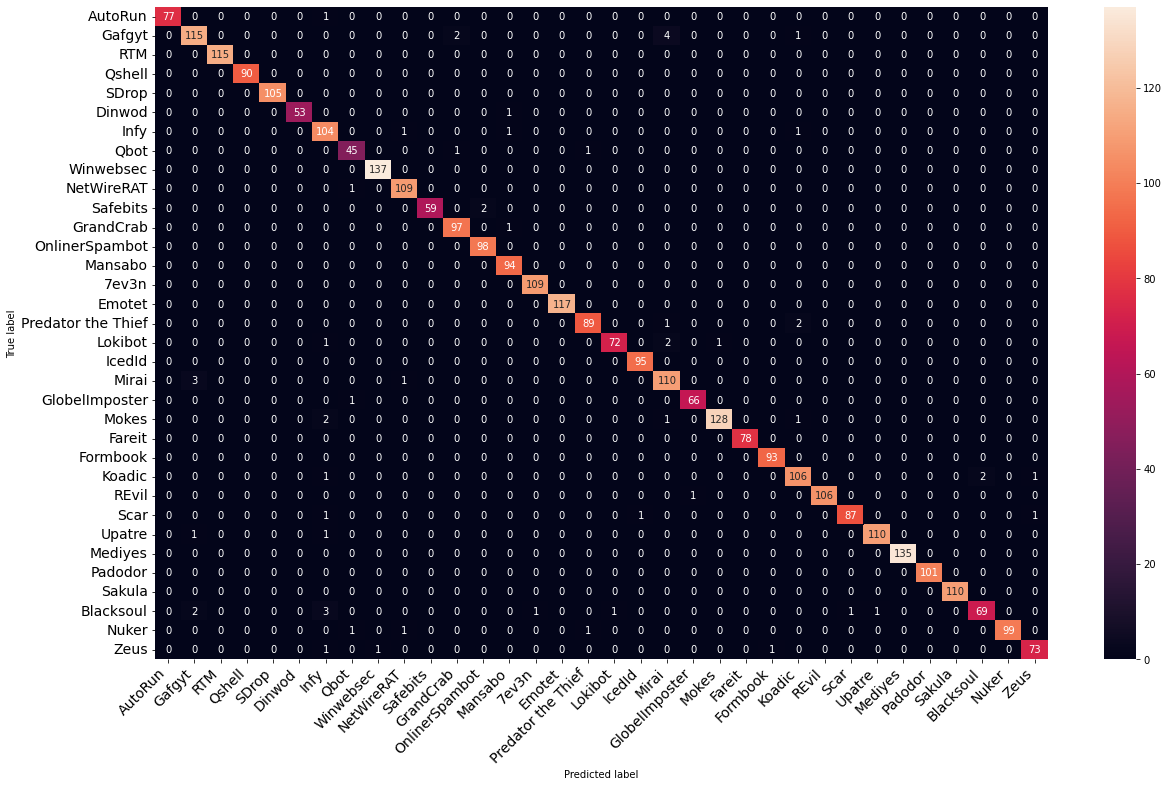

In [44]:
# Confusion Matrix
CM = confusion_matrix(cnn_actual, cnn_predict)
make_confusion_matrix(CM, class_names)

## Feature Extraction from CNN

###### Pick the Fully-Connected layer just above the softmax

In [45]:
#Pick the Fully-Connected layer just above the softmax (-3 since their also a dropout layer)
print(cnnmodel.layers[-3].name)

dropout_5


In [46]:
# Get Fully-Connected Layer
layer_name = cnnmodel.layers[-3].name
# Extraction of Features from Dual CNN Model for further use
feature_layer = Model(inputs=cnnmodel.input,outputs=cnnmodel.get_layer(layer_name).output)

In [47]:
# Extract train data from CNN feature layer
train_data=feature_layer.predict(x_train,verbose=1)
print(train_data.shape)

414/414 [==============================] - 4s 8ms/step
(13240, 512)


In [48]:
# Extract test data from CNN feature layer
test_data=feature_layer.predict(x_test,verbose=1)
print(test_data.shape)

104/104 [==============================] - 1s 8ms/step
(3310, 512)


## Random Forest

In [49]:
#Feed the extracted features with the labels to Base Random Forest
rf = RandomForestClassifier(n_estimators = 50, random_state = 42,max_depth=100, max_features="auto")
# Fit RF model
rf.fit(train_data, y_train)

RandomForestClassifier(max_depth=100, n_estimators=50, random_state=42)

In [50]:
# Make Predictions
rf_predictions = rf.predict(test_data)

In [51]:
rf_predict = np.argmax(rf_predictions, axis=1)

In [52]:
rf_actual = np.argmax(y_test, axis=1)

In [53]:
RF_results = show_results("Random Forest", rf_actual, rf_predict)

Random Forest Accuracy: 0.9643504531722055

Random Forest Precision: 0.981271597730465

Random Forest f1-Score: 0.981271597730465



In [54]:
print(f'\tRandom Forest Classification Report\n')
print(classification_report(rf_actual, rf_predict, target_names=class_names))

	Random Forest Classification Report

                    precision    recall  f1-score   support

           AutoRun       0.44      1.00      0.61        78
            Gafgyt       0.96      0.93      0.95       122
               RTM       1.00      1.00      1.00       115
            Qshell       1.00      1.00      1.00        90
             SDrop       1.00      1.00      1.00       105
            Dinwod       1.00      0.98      0.99        54
              Infy       1.00      0.90      0.95       107
              Qbot       1.00      0.91      0.96        47
         Winwebsec       0.99      1.00      1.00       137
        NetWireRAT       1.00      0.98      0.99       110
          Safebits       1.00      0.97      0.98        61
         GrandCrab       1.00      0.95      0.97        98
    OnlinerSpambot       0.98      0.95      0.96        98
           Mansabo       1.00      0.98      0.99        94
             7ev3n       1.00      1.00      1.00       109
 

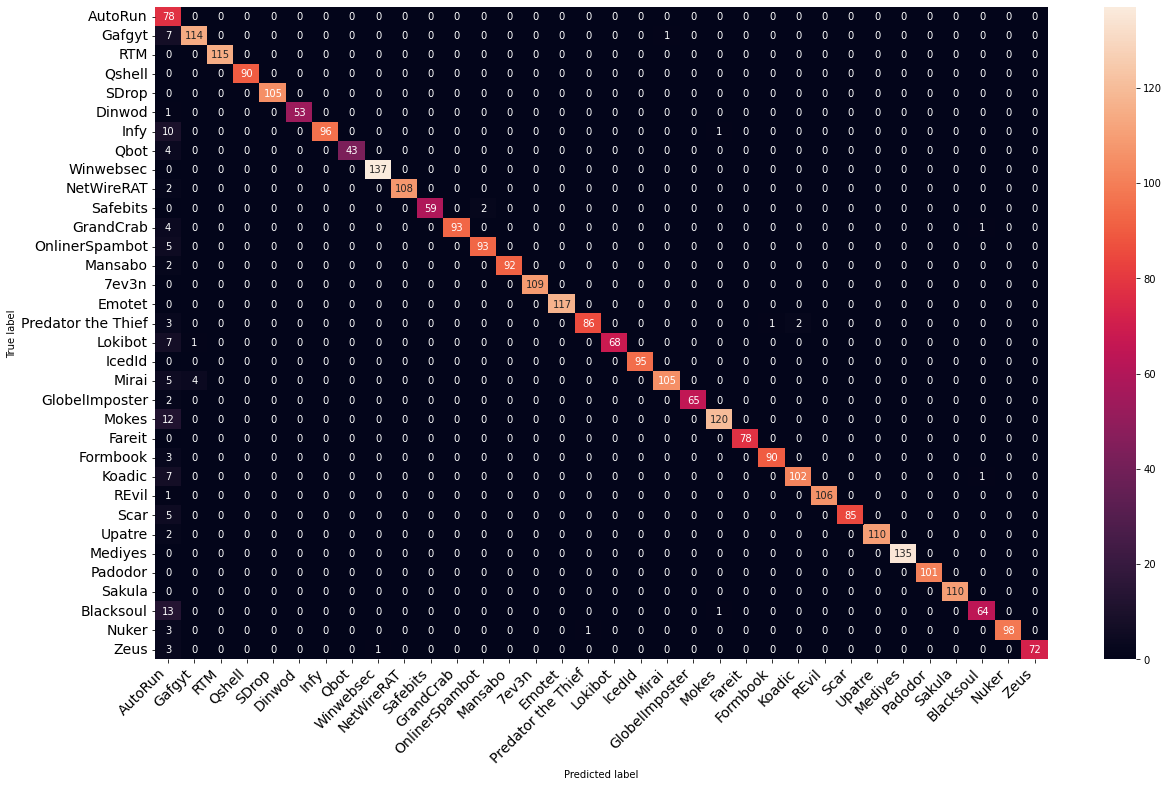

In [55]:
CM = confusion_matrix(rf_actual, rf_predict)
make_confusion_matrix(CM, class_names)

## K-Nearest Neighbor(KNN)

In [56]:
parameters = {'n_neighbors': [5,10,15,20]}

Knn = KNeighborsClassifier()

clf = GridSearchCV(Knn, parameters)
print("Searching for best hyperparameters ...")

clf.fit(train_data, y_train)
print(f'Best Hyperparameters: {clf.best_params_}')

Searching for best hyperparameters ...
Best Hyperparameters: {'n_neighbors': 5}


In [57]:
knn_pred = clf.predict(test_data)

In [58]:
knn_predict = np.argmax(knn_pred , axis=1)

In [59]:
knn_actual = np.argmax(y_test, axis=1)

In [60]:
knn_results = show_results("KNN", knn_actual, knn_predict)

KNN Accuracy: 0.9700906344410876

KNN Precision: 0.9717234099219775

KNN f1-Score: 0.9717234099219775



In [61]:
print(f'\t\t\t\tKNN Classification Report\n')
print(classification_report(knn_actual, knn_predict, target_names=class_names))

				KNN Classification Report

                    precision    recall  f1-score   support

           AutoRun       0.75      0.96      0.84        78
            Gafgyt       0.95      0.94      0.95       122
               RTM       1.00      1.00      1.00       115
            Qshell       1.00      1.00      1.00        90
             SDrop       0.99      1.00      1.00       105
            Dinwod       0.95      0.98      0.96        54
              Infy       0.96      0.87      0.91       107
              Qbot       0.98      0.94      0.96        47
         Winwebsec       0.97      1.00      0.99       137
        NetWireRAT       0.99      1.00      1.00       110
          Safebits       0.98      0.97      0.98        61
         GrandCrab       0.97      0.98      0.97        98
    OnlinerSpambot       0.95      0.98      0.96        98
           Mansabo       0.95      0.98      0.96        94
             7ev3n       1.00      1.00      1.00       109
        

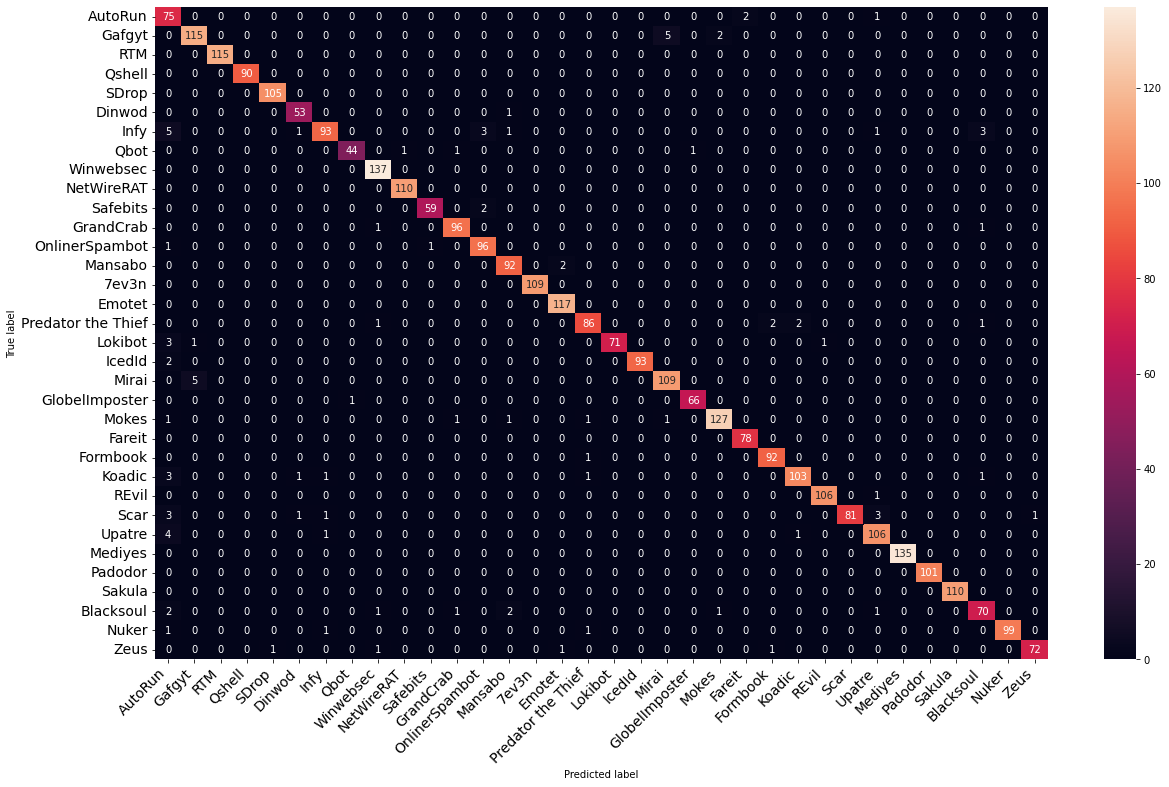

In [62]:
CM = confusion_matrix(knn_actual, knn_predict)
make_confusion_matrix(CM, class_names)

## Support Vector Machines(SVM)

In [63]:
svm = SVC()

In [64]:
# Convert Training Data to 1D array to fit in SVM
y_train = np.argmax(y_train , axis=1)

In [65]:
y_train.shape

(13240,)

In [66]:
svm.fit(train_data, y_train)

SVC()

In [67]:
svm_predict = svm.predict(test_data)

In [68]:
svm_actual = np.argmax(y_test, axis=1)

In [69]:
svm_results = show_results("SVM", svm_actual, svm_predict)

SVM Accuracy: 0.9643504531722055

SVM Precision: 0.9659382310700588

SVM f1-Score: 0.9659382310700588



In [70]:
print(f'\t\t\t\tSVM Classification Report\n')
print(classification_report(svm_actual, svm_predict, target_names=class_names))

				SVM Classification Report

                    precision    recall  f1-score   support

           AutoRun       0.97      0.92      0.95        78
            Gafgyt       0.94      0.95      0.95       122
               RTM       1.00      1.00      1.00       115
            Qshell       0.97      0.97      0.97        90
             SDrop       1.00      1.00      1.00       105
            Dinwod       0.98      0.96      0.97        54
              Infy       0.94      0.89      0.91       107
              Qbot       1.00      0.83      0.91        47
         Winwebsec       0.94      0.99      0.96       137
        NetWireRAT       1.00      0.97      0.99       110
          Safebits       0.95      0.97      0.96        61
         GrandCrab       0.98      0.96      0.97        98
    OnlinerSpambot       0.97      1.00      0.98        98
           Mansabo       0.91      0.98      0.94        94
             7ev3n       1.00      1.00      1.00       109
        

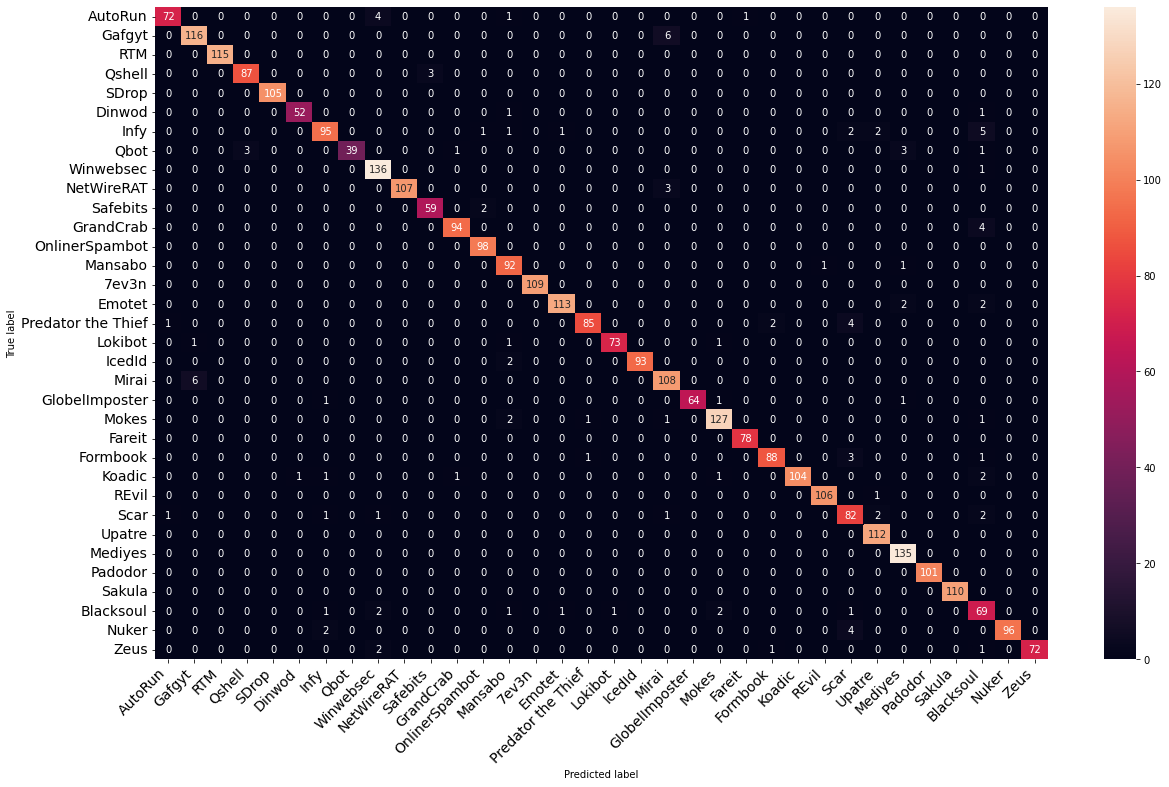

In [71]:
CM = confusion_matrix(svm_actual, svm_predict)
make_confusion_matrix(CM, class_names)

In [72]:
cnnmodel.save('gray98.h5')